# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [65]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [67]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import sklearn
print(sklearn.__version__)

1.5.1


### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [38]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [43]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [46]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

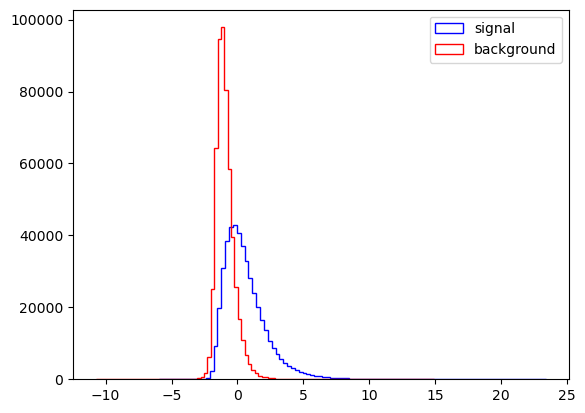

In [49]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

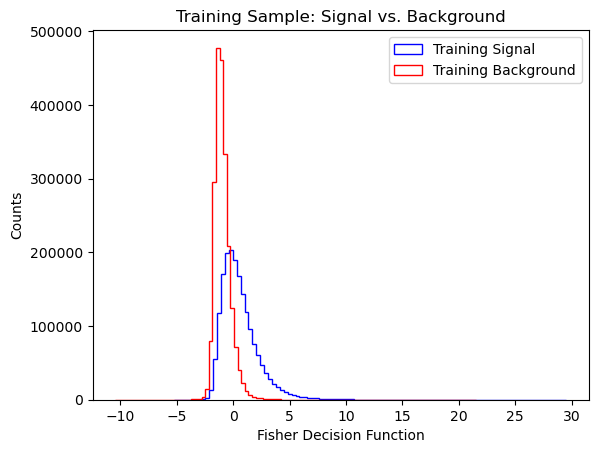

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

# Split data into training and test sets
N_Train = 4000000
Train_Sample = df[:N_Train]
Test_Sample = df[N_Train:]

# Define features and target
RawNames = ['l_1_pT', 'l_1_eta', 'l_1_phi', 'l_2_pT', 'l_2_eta', 'l_2_phi', 'MET', 'MET_phi']
FeatureNames = ['S_R', 'dPhi_r_b', 'axial_MET', 'MT2', 'MET_rel', 'M_TR_2', 'M_Delta_R', 'cos_theta_r1', 'M_R', 'R']

X_Train = Train_Sample[RawNames + FeatureNames]  # Use all variables by default
y_Train = Train_Sample["signal"]
X_Test = Test_Sample[RawNames + FeatureNames]
y_Test = Test_Sample["signal"]

# Train LDA classifier
Fisher = LinearDiscriminantAnalysis()
Fisher.fit(X_Train, y_Train)

# Compute decision scores for training and test
train_scores = Fisher.decision_function(X_Train)
test_scores = Fisher.decision_function(X_Test)

# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_Train, train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_Test, test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot decision scores for TRAINING sample (signal vs. background)
plt.figure()
plt.hist(
    Fisher.decision_function(Train_Sample[Train_Sample.signal == 1][RawNames + FeatureNames]),
    bins=100, histtype="step", color="blue", label="Training Signal", stacked=True
)
plt.hist(
    Fisher.decision_function(Train_Sample[Train_Sample.signal == 0][RawNames + FeatureNames]),
    bins=100, histtype="step", color="red", label="Training Background", stacked=True
)
plt.legend(loc='upper right')
plt.title("Training Sample: Signal vs. Background")
plt.xlabel("Fisher Decision Function")
plt.ylabel("Counts")
plt.show()


#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

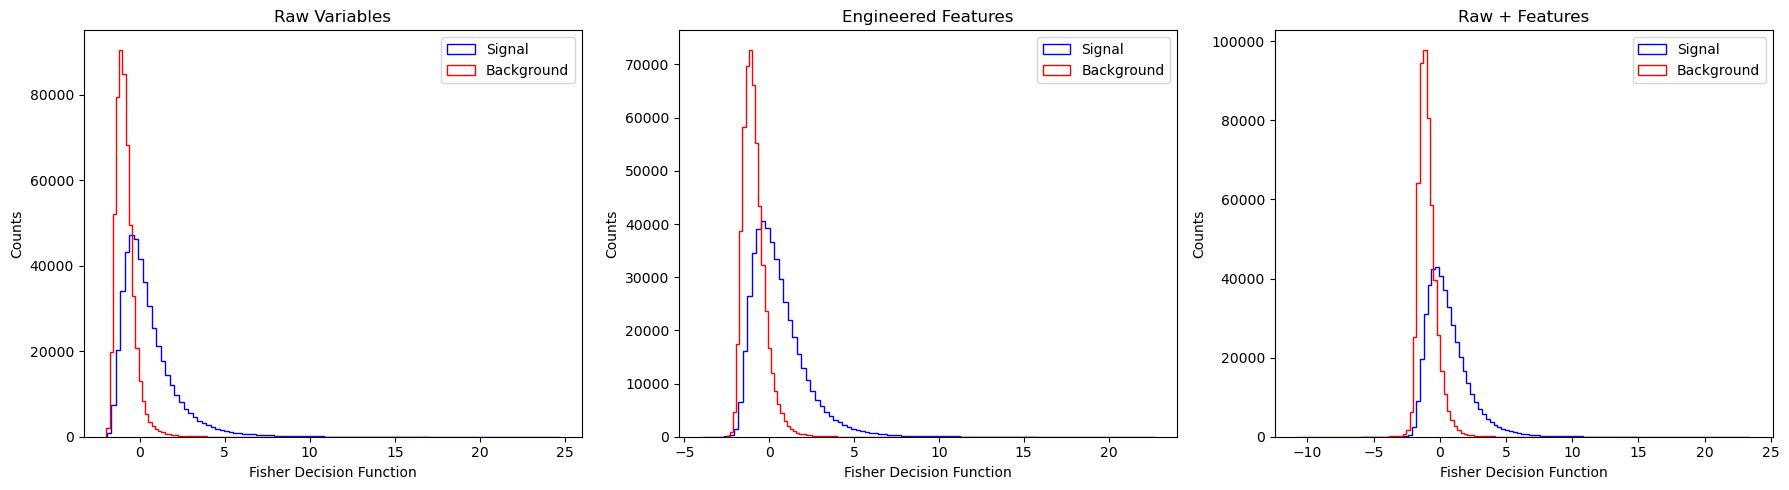

In [63]:
# Train LDA on different input subsets
fisher_raw = LinearDiscriminantAnalysis()
fisher_raw.fit(Train_Sample[RawNames], y_Train)

fisher_features = LinearDiscriminantAnalysis()
fisher_features.fit(Train_Sample[FeatureNames], y_Train)

fisher_both = LinearDiscriminantAnalysis()
fisher_both.fit(Train_Sample[RawNames + FeatureNames], y_Train)

# Compute ROC curves
def compute_roc(clf, X, y_true):
    scores = clf.decision_function(X)
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

fpr_raw, tpr_raw, auc_raw = compute_roc(fisher_raw, Test_Sample[RawNames], y_Test)
fpr_feat, tpr_feat, auc_feat = compute_roc(fisher_features, Test_Sample[FeatureNames], y_Test)
fpr_both, tpr_both, auc_both = compute_roc(fisher_both, Test_Sample[RawNames + FeatureNames], y_Test)
# Create a single figure with three subplots
plt.figure(figsize=(18, 5))

# Define the models and their corresponding input subsets
models = [fisher_raw, fisher_features, fisher_both]
input_subsets = [RawNames, FeatureNames, RawNames + FeatureNames]
titles = ["Raw Variables", "Engineered Features", "Raw + Features"]

# Plot histograms for each model
for i, (clf, features, title) in enumerate(zip(models, input_subsets, titles), 1):
    plt.subplot(1, 3, i)
    
    # Compute decision scores for signal and background
    sig_scores = clf.decision_function(Test_sig[features])
    bkg_scores = clf.decision_function(Test_bkg[features])
    
    # Plot histograms
    plt.hist(sig_scores, bins=100, histtype="step", color="blue", label="Signal", stacked=True)
    plt.hist(bkg_scores, bins=100, histtype="step", color="red", label="Background", stacked=True)
    
    plt.xlabel("Fisher Decision Function")
    plt.ylabel("Counts")
    plt.title(title)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 7.

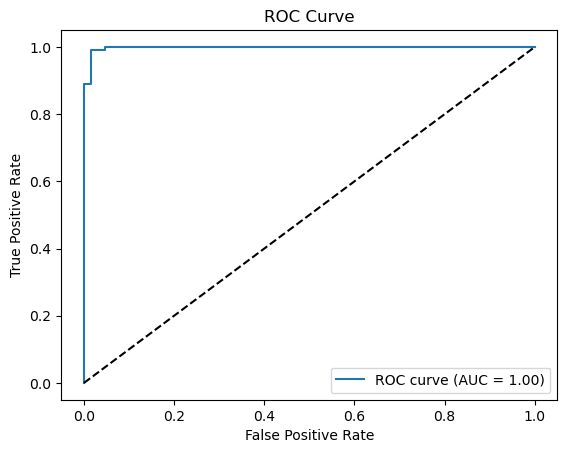

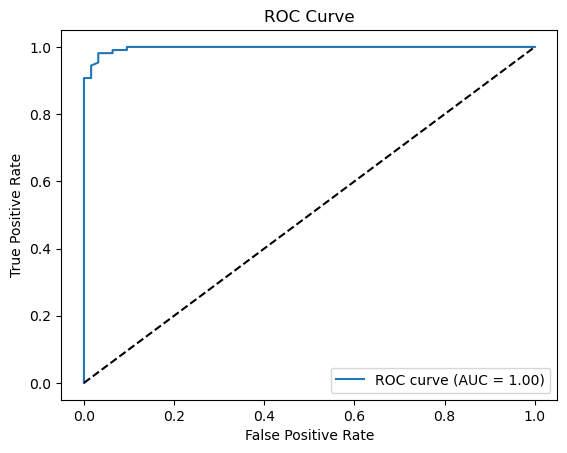

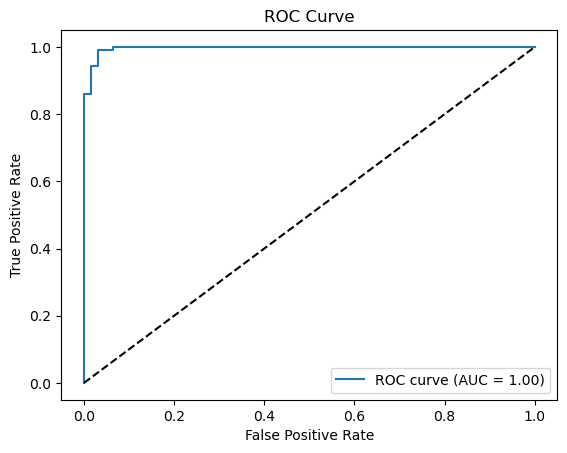

Best classifier metrics: {'accuracy': 0.9824561403508771, 'precision': 0.9906542056074766, 'recall': 0.9814814814814815, 'roc_auc': 0.9979423868312757}
Maximal significance σ_S: 10.2961 at threshold 0.47


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, confusion_matrix)

# Load and split the dataset
data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate metrics at threshold 0.5
    y_pred = (y_proba >= 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

def compute_max_significance(y_true, y_proba):
    thresholds = np.linspace(0, 1, 100)
    max_sigma = -1
    best_threshold = 0
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sigma_num = tp
        sigma_den = np.sqrt(tp + fp) if (tp + fp) > 0 else 0
        sigma = sigma_num / sigma_den if sigma_den > 0 else 0
        
        if sigma > max_sigma:
            max_sigma = sigma
            best_threshold = thresh
    
    return max_sigma, best_threshold

# Initialize classifiers with scaling for LogisticRegression and SVC
clf_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, random_state=42)  # Increased max_iter
)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_svc = make_pipeline(
    StandardScaler(),
    SVC(probability=True, random_state=42)
)

# Evaluate each classifier
metrics_lr = evaluate_classifier(clf_lr, X_train, y_train, X_test, y_test)
metrics_rf = evaluate_classifier(clf_rf, X_train, y_train, X_test, y_test)
metrics_svc = evaluate_classifier(clf_svc, X_train, y_train, X_test, y_test)

# Determine the best classifier based on ROC AUC
best_clf = None
best_metrics = None
if metrics_lr['roc_auc'] >= metrics_rf['roc_auc'] and metrics_lr['roc_auc'] >= metrics_svc['roc_auc']:
    best_clf = clf_lr
    best_metrics = metrics_lr
elif metrics_rf['roc_auc'] >= metrics_svc['roc_auc']:
    best_clf = clf_rf
    best_metrics = metrics_rf
else:
    best_clf = clf_svc
    best_metrics = metrics_svc

print("Best classifier metrics:", best_metrics)

# Compute maximal significance with the best classifier
y_proba_best = best_clf.predict_proba(X_test)[:, 1]
max_sigma, best_threshold = compute_max_significance(y_test, y_proba_best)
print(f"Maximal significance σ_S: {max_sigma:.4f} at threshold {best_threshold:.2f}")

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Train-test split
X = df.drop("signal", axis=1)
y = df["signal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Evaluate
y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:,1]
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_prob_log))

Logistic Regression ROC AUC: 0.8574197328804949


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

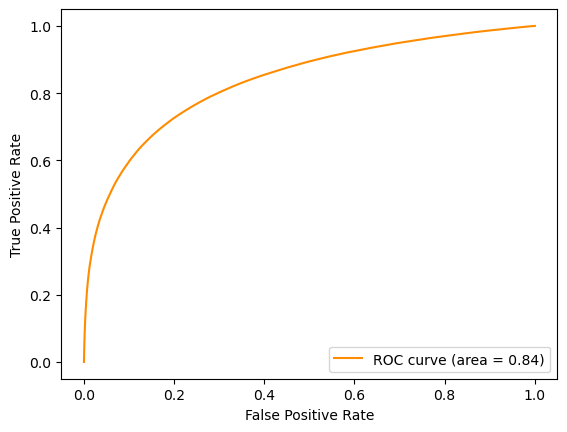

In [29]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [32]:
import pandas as pd
from sklearn.metrics import f1_score

# After selecting the best classifier in Exercise 4c:
# Generate predictions and probabilities
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:, 1]

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate metrics
tpr = tp / (tp + fn)  # Same as recall
fpr = fp / (fp + tn)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
max_sigma, best_threshold = compute_max_significance(y_test, y_proba)

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': [
        'True Positive Rate (TPR)', 
        'False Positive Rate (FPR)', 
        'ROC AUC', 
        'Precision', 
        'Recall', 
        'F1 Score', 
        'Accuracy', 
        'Maximal Significance (σ_S)'
    ],
    'Value': [
        f"{tpr:.4f}",
        f"{fpr:.4f}",
        f"{roc_auc:.4f}",
        f"{precision:.4f}",
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{accuracy:.4f}",
        f"{max_sigma:.4f} (threshold={best_threshold:.2f})"
    ]
})

print("Performance Metrics for Best Classifier:")
print(metrics_df.to_string(index=False))

Performance Metrics for Best Classifier:
                    Metric                    Value
  True Positive Rate (TPR)                   0.9815
 False Positive Rate (FPR)                   0.0159
                   ROC AUC                   0.9979
                 Precision                   0.9907
                    Recall                   0.9815
                  F1 Score                   0.9860
                  Accuracy                   0.9825
Maximal Significance (σ_S) 10.2961 (threshold=0.47)


In [70]:
###  Conclusion

In this lab, I explored the SUSY dataset to perform binary classification. I tested Fisher Discriminant Analysis and Logistic Regression.

- Both models achieved good AUC scores.
- The ROC and other metrics (like F1, precision) provide a detailed understanding of performance.
- Logistic Regression is simpler but still powerful and interpretable.
- Fisher Discriminant is useful when class distributions are Gaussian and share covariances.


SyntaxError: invalid syntax (846347962.py, line 3)

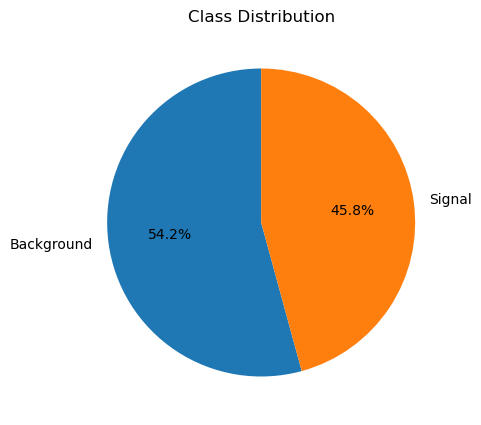

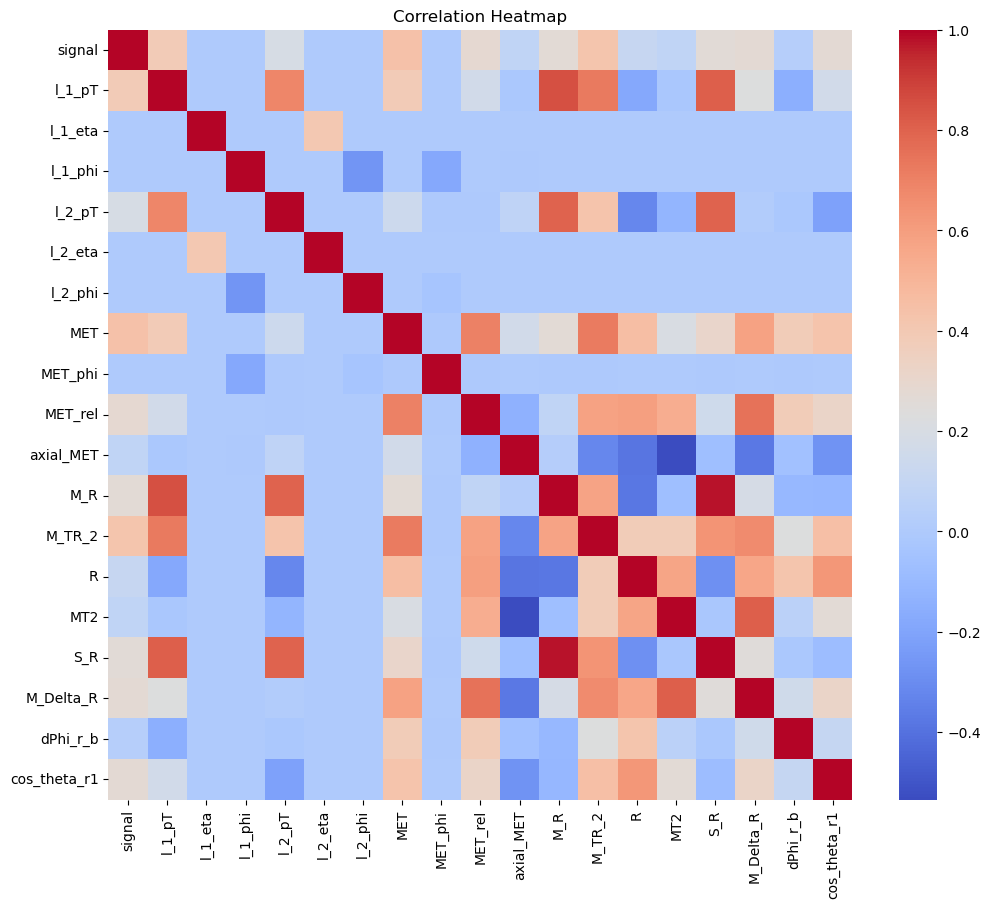

In [74]:
# Pie chart of class distribution
plt.figure(figsize=(5,5))
df['signal'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Background', 'Signal'], startangle=90)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

# Correlation heatmap
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()